# Convex unmixer

Notebook that uses a network representation of sample localities to unmix sedimentary geochemical data. 

In [1]:
import os
import sys
print(sys.version)
print(os.getcwd())

import cvxpy as cp
import geochem_inverse_optimize as gio
import matplotlib.pyplot as plt

3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
/home/alex/Documents/scripts/faster-unmixer-richard


## Set up and solve unmixing problem

In [2]:
sample_network, sample_adjacency = gio.get_sample_graphs("data/")

# gio.plot_network(sample_network)

obs_data, element_list = gio.get_sample_data("data/geochem_no_dupes.dat")

primary_terms = gio.get_primary_terms(sample_network=sample_network, obs_data=obs_data, element_list=element_list)

regularizer_terms = gio.get_regularizer_terms(sample_network=sample_network, adjacency_graph=sample_adjacency)

if not regularizer_terms:
    print("WARNING: No regularizer terms found!")

# Build the objective and constraints
regularizer_strength = 1e-3
objective = cp.norm(cp.vstack(primary_terms))
if regularizer_terms:
  objective += regularizer_strength * cp.norm(cp.vstack(regularizer_terms))
constraints = []

# Create and solve the problem
print("Compiling and solving problem...")
problem = cp.Problem(cp.Minimize(objective), constraints)
# Solvers that can handle this problem type include:
# ECOS, SCS
# See: https://www.cvxpy.org/tutorial/advanced/index.html#choosing-a-solver
objective_value = problem.solve(solver=cp.SCS, verbose=True, max_iters=10000) 

Compiling and solving problem...
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 29464
eps = 1.00e-04, alpha = 1.50, max_iters = 10000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 4348, constraints m = 10144
Cones:	linear vars: 4347
	soc vars: 5797, soc blks: 1450
Setup time: 1.13e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 6.99e+20  1.30e+21  1.00e+00 -4.29e+22  8.36e+22  7.96e+22  6.05e-03 
   100| 1.08e-01  4.14e-02  1.62e-02  5.21e+01  5.04e+01  6.04e-15  1.71e-01 
   200| 6.40e-02  2.93e-02  2.42e-03  4.76e+01  4.74e+

/home/alex/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


## Extract results

In [3]:
soldf = gio.get_solution_dataframe(sample_network=sample_network, obs_data=obs_data)
upstdf = gio.get_upstream_dataframe(sample_network=sample_network)
upst_areas = gio.get_unique_upstream_areas(sample_network=sample_network)   

## Visualise results

Visualising output for Beryllium.

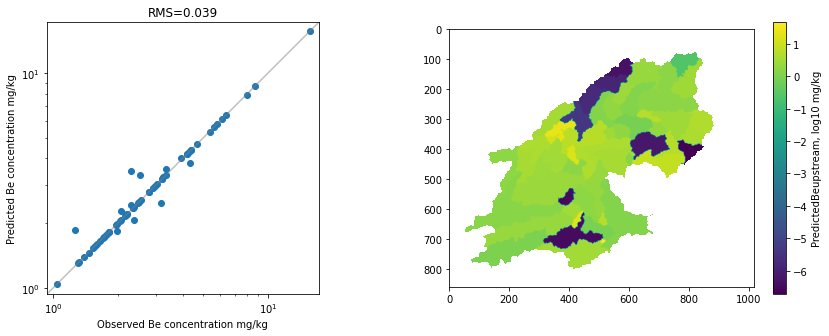

In [7]:
be_map = gio.get_upstream_concentration_map(upstream_dataframe=upstdf,areas=upst_areas,elem='Be')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
gio.visualise_downstream(soldf,'Be')
plt.subplot(1,2,2)
gio.visualise_upstream(be_map,'Be') # Set vmin to 0 to observe more realistic output
plt.show()